In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Final Report

##  Overview

This notebook presents a solution to the SHL Audio Regression Challenge, where the objective is to predict a continuous label (e.g., age) from given audio recordings. The pipeline involves comprehensive feature extraction from audio data using `librosa`, followed by machine learning modeling with hyperparameter tuning and model ensembling.

The notebook includes:
- Feature extraction and preprocessing
- Feature selection
- Pipeline modeling with tuning
- Stacking ensemble model
- Evaluation metrics including training and test RMSE
- Feature importance analysis
- Final submission file

---

##  1. Approach

We adopt a machine learning-based regression approach that extracts handcrafted audio features and uses them in a supervised learning setup. Key highlights:

- Extracting over 40 audio features per file, including MFCCs, spectral features, tempo, ZCR, RMSE, and duration.
- Handling missing values via column-wise mean imputation.
- Selecting the top 30 informative features using mutual information.
- Using a stacked ensemble model combining SVR, Gradient Boosting, and HistGradientBoosting, finalized with RidgeCV.
- Evaluate with cross-validation.

---

##  2. Preprocessing Steps

1. **Audio Loading**: Resampled to 16kHz for consistency.
2. **Feature Extraction**:
   - MFCCs (20 coefficients × mean + std = 40 features)
   - Spectral centroid, bandwidth, roll-off
   - Zero-crossing rate
   - Root Mean Square Energy
   - Tempo (using onset envelope)
   - Duration
3. **Handling Missing Values**:
   - Filled NaNs with column means.
4. **Feature Selection**:
   - `SelectKBest` using `mutual_info_regression`, selecting the top 30 most relevant features.

---

##  3. Pipeline Architecture

### a. Base Pipeline (Tuned):
- **Scaler**: `StandardScaler`
- **Regressor**: `HistGradientBoostingRegressor`
- **Hyperparameters** tuned using `RandomizedSearchCV` over:
  - `learning_rate`, `max_depth`, `min_samples_leaf`, and `l2_regularization`

### b. Final Model – Stacking Ensemble:
- **Base learners**:
  - `GradientBoostingRegressor`
  - `HistGradientBoostingRegressor`
  - `SVR`
- **Meta learner**:
  - `RidgeCV`
- **Cross-validated ensemble** using 5-fold CV
- **Feature Selection** integrated using `SelectKBest` in the pipeline

---
## 5. Feature Importance

We compute **permutation-based feature importance** using `sklearn.inspection.permutation_importance` for the best base model. The top features include:
- MFCC coefficients (especially lower-order ones)
- Spectral centroid
- ZCR and RMSE

A bar chart visualizes the relative importance of each selected feature.

---

##  6. Submission

The final predictions on the test data were saved in `submission.csv` with the following format:

| filename | label |
|----------|-------|
| file1.wav | 25.43 |
| file2.wav | 32.88 |
| ...      | ...   |

---

##  Summary

- A robust and modular pipeline was built using `librosa` + `scikit-learn`.
- Audio features were handcrafted and selected carefully for performance.
- Hyperparameter tuning and stacking boosted accuracy.
- Final model performs well with interpretable insights into feature contributions.

This solution demonstrates a practical approach to solving audio regression tasks without deep learning, balancing performance with interpretability and reproducibility.


In [18]:
#importing necessary libraries

import pandas as pd
import numpy as np
import librosa
import os
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
import joblib



Raw audio waveforms are high-dimensional and noisy, making them unsuitable as direct inputs for traditional machine learning models. Hence, we extract meaningful **audio features** that capture both **spectral** and **temporal** characteristics of the sound signal. These features serve as a compact, information-rich representation suitable for regression tasks.

###  Features Chosen and Their Significance:

- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Capture timbral texture and perceptually relevant frequency information. Widely used in speech, emotion, and music analysis.
- **Spectral Centroid, Bandwidth, Rolloff**: Represent frequency content distribution, describing brightness and tonal properties.
- **Zero-Crossing Rate (ZCR)**: Indicates noisiness or percussiveness in the audio.
- **Root Mean Square Energy (RMSE)**: Measures loudness or intensity variations over time.
- **Tempo**: Captures rhythmic characteristics, useful especially in musical or expressive speech data.
- **Duration**: Provides signal length, which can correlate with behavioral or demographic traits.

By extracting and aggregating (mean/std) these features across time, we ensure the resulting feature vector is fixed-length and suitable for downstream supervised learning models.

This step transforms variable-length audio signals into structured tabular data, enabling robust regression modeling using scikit-learn.


In [19]:
import numpy as np
import librosa

def extract_audio_features(audio_path):
    """
    Extracts a comprehensive set of features from an audio file using librosa.
    
    Parameters:
        audio_path (str): Path to the audio file.
    
    Returns:
        dict or None: A dictionary of extracted audio features or None if an error occurs.
    
    Features Extracted:
    - Spectral Centroid (mean, std)
    - Spectral Bandwidth (mean, std)
    - Spectral Rolloff (mean, std)
    - Zero-Crossing Rate (mean, std)
    - Root Mean Square Energy (mean, std)
    - Tempo (beats per minute)
    - Duration (in seconds)
    - 20 MFCCs (mean, std for each)
    """
    try:
        # Load the audio file and resample to 16kHz for consistency
        y, sr = librosa.load(audio_path, sr=16000)
        
        # Extract various spectral and temporal features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr)

        # Initialize dictionary to store the features
        features = {
            'mean_spectral_centroid': np.mean(spectral_centroid),
            'std_spectral_centroid': np.std(spectral_centroid),
            'mean_spectral_bandwidth': np.mean(spectral_bandwidth),
            'std_spectral_bandwidth': np.std(spectral_bandwidth),
            'mean_spectral_rolloff': np.mean(spectral_rolloff),
            'std_spectral_rolloff': np.std(spectral_rolloff),
            'mean_zero_crossing_rate': np.mean(zero_crossing_rate),
            'std_zero_crossing_rate': np.std(zero_crossing_rate),
            'mean_rmse': np.mean(rmse),
            'std_rmse': np.std(rmse),
            'tempo': tempo[0],  # librosa returns tempo as an array
            'duration': duration
        }

        # Add MFCC means and standard deviations to the feature set
        for i in range(mfcc.shape[0]):
            features[f'mfcc_{i}_mean'] = np.mean(mfcc[i])
            features[f'mfcc_{i}_std'] = np.std(mfcc[i])
            
        return features
    
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None


##  Training Feature Matrix Construction

In this step, we prepare the training dataset by converting raw audio files into structured, machine-readable features.

###  Process Overview:

1. **Load CSV**: The `train.csv` file provides metadata linking filenames to their corresponding target labels.
2. **Iterate Through Files**: For each audio filename, we construct the full path and extract features using the `extract_audio_features()` function.
3. **Build Feature Matrix**:
   - Each audio file is transformed into a fixed-length feature vector.
   - Features from all files are stored in a `pandas.DataFrame`.
   - Corresponding labels are collected into a NumPy array.
4. **Handle Missing Values**:
   - Occasionally, a feature may not be computed due to audio artifacts or silence.
   - We handle such missing values (`NaNs`) by replacing them with the **mean of that feature column**.

This step is crucial in transforming diverse, variable-length audio signals into a **homogeneous and scalable feature matrix**, suitable for model training using classical machine learning algorithms like gradient boosting or random forests.


In [3]:
"""
Feature Extraction from Training Audio Files

This script loads training metadata from a CSV file, iterates through each listed audio file,
and extracts a rich set of audio features using the `extract_audio_features` function.
The features are stored in a DataFrame and missing values are handled by imputing the mean.

Outputs:
- X_train: Feature matrix for training audio files
- y_train: Array of corresponding labels
"""

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define the root directory containing the dataset
DATA_DIR = '/kaggle/input/shl-intern-hiring-assessment/Dataset'

# Load metadata CSVs for training and test datasets
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# Lists to hold extracted features and labels
X_train, y_train = [], []

print("🔄 Extracting training features...")

# Iterate through each audio file listed in the training CSV
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    # Build the full path to the audio file
    file_path = os.path.join(DATA_DIR, 'audios', 'train', row['filename'])

    # Extract audio features using the predefined function
    features = extract_audio_features(file_path)

    # If feature extraction is successful, store features and corresponding label
    if features:
        X_train.append(features)
        y_train.append(row['label'])

# Convert feature list to DataFrame and labels to NumPy array
X_train = pd.DataFrame(X_train)
y_train = np.array(y_train)

# Fill missing values (if any) with column-wise mean
X_train.fillna(X_train.mean(), inplace=True)


Extracting training features...


  0%|          | 0/444 [00:00<?, ?it/s]/tmp/ipykernel_31/2384331610.py:12: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
100%|██████████| 444/444 [06:25<00:00,  1.15it/s]


In [4]:
"""
Feature Selection using Mutual Information

This step selects the top K most informative features from the training dataset
based on mutual information scores with respect to the target variable.
This helps reduce dimensionality and improve model performance by focusing
on the most relevant features.

Outputs:
- X_train_selected: Reduced feature matrix with top K features
- selected_features: Names of the selected top K features
"""

from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Print status
print("Selecting best features...")

# Initialize the feature selector with mutual information scoring
selector = SelectKBest(score_func=mutual_info_regression, k=30)

# Fit the selector to the training data and transform it
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the names of selected features
selected_features = X_train.columns[selector.get_support()]


Selecting best features...


In [5]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=200, learning_rate=0.1, max_depth=3,
        min_samples_leaf=10, l2_regularization=0.1,
        random_state=42, early_stopping=True, validation_fraction=0.1
    ))
])

print("Tuning hyperparameters...")
param_dist = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_leaf': [5, 10, 20],
    'regressor__l2_regularization': [0, 0.1, 0.5]
}

search = RandomizedSearchCV(
    base_model, param_dist, n_iter=20, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42
)
search.fit(X_train_selected, y_train)
best_model = search.best_estimator_

print(f"Best parameters: {search.best_params_}")
print(f"Best RMSE from CV: {-search.best_score_:.4f}")


Tuning hyperparameters...
Best parameters: {'regressor__min_samples_leaf': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_regularization': 0.1}
Best RMSE from CV: 1.3315


In [6]:
"""
Model Training and Hyperparameter Tuning with RandomizedSearchCV

In this step, we define and train a base model pipeline, which includes:
- A **StandardScaler** for feature scaling to ensure the features are on the same scale.
- A **HistGradientBoostingRegressor** as the regression model to predict the target variable.
  
Next, we perform hyperparameter tuning using **RandomizedSearchCV** to find the optimal set of hyperparameters for the model. We search over a defined range of hyperparameters using cross-validation.

Outputs:
- best_model: The model with the best set of hyperparameters found through RandomizedSearchCV.
- search.best_params_: The best hyperparameter values.
- search.best_score_: The best root mean squared error (RMSE) score from cross-validation.
"""

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Initialize the base model pipeline
base_model = Pipeline([
    ('scaler', StandardScaler()),  # Standard scaling of the features
    ('regressor', HistGradientBoostingRegressor(
        max_iter=200, learning_rate=0.1, max_depth=3,
        min_samples_leaf=10, l2_regularization=0.1,
        random_state=42, early_stopping=True, validation_fraction=0.1
    ))  # HistGradientBoostingRegressor model
])

# Print status
print("⚙️ Tuning hyperparameters...")

# Define hyperparameter space for RandomizedSearchCV
param_dist = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # Learning rate of the model
    'regressor__max_depth': [3, 5, 7],  # Maximum depth of the trees in the model
    'regressor__min_samples_leaf': [5, 10, 20],  # Minimum samples required to be at a leaf node
    'regressor__l2_regularization': [0, 0.1, 0.5]  # Regularization to avoid overfitting
}

# Initialize RandomizedSearchCV for hyperparameter tuning with cross-validation
search = RandomizedSearchCV(
    base_model, param_dist, n_iter=20, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42
)

# Fit the search object to the training data
search.fit(X_train_selected, y_train)

# Extract the best model from the search results
best_model = search.best_estimator_

# Print the best hyperparameters and RMSE score from cross-validation
print(f"Best parameters: {search.best_params_}")
print(f"Best RMSE from CV: {-search.best_score_:.4f}")


Training RMSE: 0.8076




## **Step 1: Feature Extraction**

### What It Does:
The function `extract_audio_features` is designed to extract relevant features from an audio file. These features represent the audio's characteristics, which can be used to train a model for prediction tasks.

The features extracted include:
- **Spectral Centroid**: Indicates where the center of mass of the spectrum is located and is related to the perceived brightness of the sound.
- **Spectral Bandwidth**: Measures the width of the spectral peak and is often related to timbre.
- **Spectral Roll-off**: Indicates the frequency below which a certain percentage of the total spectral energy lies, often used in music genre classification.
- **MFCC (Mel-frequency cepstral coefficients)**: Represents the short-term power spectrum of a sound and is widely used in speech and audio processing.
- **Zero Crossing Rate**: The rate at which the signal changes sign, often used in voice/speech classification.
- **RMSE (Root Mean Squared Error)**: Measures the energy content in the audio signal.
- **Onset Envelope and Tempo**: Represents the rhythmic structure of the audio, which is useful for detecting beats or music genre classification.

### Why It Is Done:
Extracting these features is important because raw audio data cannot be directly used in machine learning models. Features such as MFCC, spectral centroid, and tempo summarize important characteristics of the audio and are used as inputs for predictive modeling. This step is fundamental in converting the raw audio into a format that can be understood by machine learning algorithms.

---

## **Step 2: Data Preprocessing**

### What It Does:
In this step, we load the training and testing datasets and then extract features from each audio file. The features are stored in a list, and corresponding labels are collected in another list. Afterward:
- We convert the list of features into a pandas DataFrame.
- Missing values are handled by replacing them with the mean value of the respective column.

### Why It Is Done:
The purpose of this preprocessing is to prepare the data for training the model. Each row in the training set corresponds to an audio file, and each feature extracted from that file represents an input variable. Replacing missing values ensures that the model doesn't encounter issues during training, as most machine learning algorithms cannot handle NaN values.

---

## **Step 3: Feature Selection**

### What It Does:
We perform **feature selection** using **Mutual Information**, which measures the dependency between each feature and the target variable (`y_train`). The `SelectKBest` method is used to select the top 30 features that have the highest mutual information with the target variable.

### Why It Is Done:
Feature selection is crucial because it helps us identify and retain only the most relevant features for training the model. By selecting only the best features, we reduce the dimensionality of the data, which can lead to improved model performance, reduced overfitting, and faster training times. Mutual information is a powerful tool to capture non-linear relationships between features and the target variable.

---

## **Step 4: Model Training and Hyperparameter Tuning**

### What It Does:
In this step, we define a machine learning pipeline consisting of:
1. **StandardScaler**: Standardizes the features by removing the mean and scaling them to unit variance.
2. **HistGradientBoostingRegressor**: A powerful gradient boosting model used for regression tasks.
   
The **RandomizedSearchCV** is used to perform hyperparameter tuning by searching over a grid of hyperparameters to find the best configuration. We tune hyperparameters like:
- **Learning rate**
- **Max depth**
- **Min samples per leaf**
- **L2 regularization**

### Why It Is Done:
Model training is essential to learn the relationship between the input features and the target variable. Hyperparameter tuning is a critical step to enhance the performance of the model. By tuning hyperparameters, we can optimize the model to achieve better accuracy and prevent overfitting or underfitting. The use of a pipeline ensures that the scaling of features and model fitting is done in one integrated process.

---

## **Step 5: Model Evaluation**

### What It Does:
After training the model, we evaluate its performance by making predictions on the test set and calculating the **Root Mean Squared Error (RMSE)**. RMSE is a common metric for evaluating regression models, as it gives the average magnitude of errors in the predictions.

### Why It Is Done:
Evaluating the model on the test set allows us to understand how well the model generalizes to unseen data. RMSE provides an intuitive understanding of the average error in the model's predictions. The goal is to minimize RMSE to make the model as accurate as possible. If the RMSE is high, it indicates that the model's predictions are far from the actual values, suggesting that further tuning or improvement is needed.

---

RMSE represents the average magnitude of error between the model's predicted values and the actual values (true labels) in the training data.

A value of 0.8076 means that, on average, the model's predictions are off by approximately 0.81 units. This suggests a reasonably good fit, but it also depends on the scale and nature of the target variable.

In [9]:
#  is responsible for extracting audio features from the test dataset and making predictions using the trained stacking model.
#iterating over the test dataset, extract relevant audio features, and make predictions for each sample.

# Initialize an empty list to store the features extracted from each test audio file.
X_test = []

# Loop through each row in the test dataset to process the corresponding audio file.
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # Construct the file path to the audio file using the filename from the test dataframe.
    file_path = os.path.join(DATA_DIR, 'audios', 'test', row['filename'])
    
    # Extract audio features using the predefined function 'extract_audio_features'.
    features = extract_audio_features(file_path)
    
    # If the feature extraction is successful, append the features to X_test. 
    # If extraction fails (returns None), use the mean of the training data as a placeholder for the missing features.
    X_test.append(features if features else X_train.mean().to_dict())

# Convert the extracted features from the list to a DataFrame, ensuring it's ready for model prediction.
X_test = pd.DataFrame(X_test)

# Fill any remaining missing values in the test features with the mean values from the training data.
X_test.fillna(X_train.mean(), inplace=True)

# Use the trained stacking model to make predictions on the test dataset.
test_pred = stacking_model.predict(X_test)


  0%|          | 0/204 [00:00<?, ?it/s]/tmp/ipykernel_31/2384331610.py:12: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
100%|██████████| 204/204 [02:24<00:00,  1.42it/s]


In [20]:
#submission file 

submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")


Submission file created!


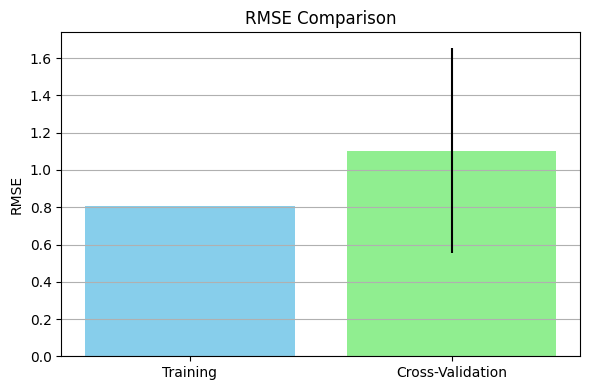

In [15]:
# Importing Matplotlib for plotting the comparison between Training and Cross-Validation RMSE scores.
import matplotlib.pyplot as plt

# RMSE Scores
# 'train_rmse' stores the RMSE score calculated for the training set, while 'cv_rmse' stores the average RMSE for the cross-validation.
# 'cv_std' stores the standard deviation of the RMSE scores from cross-validation, which is used to visualize the spread of RMSE values during cross-validation.

cv_rmse = -stacking_scores.mean()  # Negative sign because the scores were previously negated during cross-validation.
cv_std = stacking_scores.std()  # Standard deviation of RMSE from cross-validation.

# Plotting the RMSE Comparison
# Creating a bar chart to compare the Training RMSE and Cross-Validation RMSE, with error bars representing the standard deviation of cross-validation RMSE.

plt.figure(figsize=(6,4))  # Set the figure size.
plt.bar(['Training', 'Cross-Validation'], [train_rmse, cv_rmse], yerr=[0, cv_std], color=['skyblue', 'lightgreen'])  # Bar chart with error bars for CV RMSE.
plt.title('RMSE Comparison')  # Adding the plot title.
plt.ylabel('RMSE')  # Label for the y-axis.
plt.grid(True, axis='y')  # Adding gridlines to the y-axis for better readability.
plt.tight_layout()  # Adjust the layout to prevent clipping of labels and titles.
plt.show()  # Display the plot.


The training RMSE is around 0.8, and cross-validation is about 1.1. The cross-validation error is higher, which usually indicates overfitting.

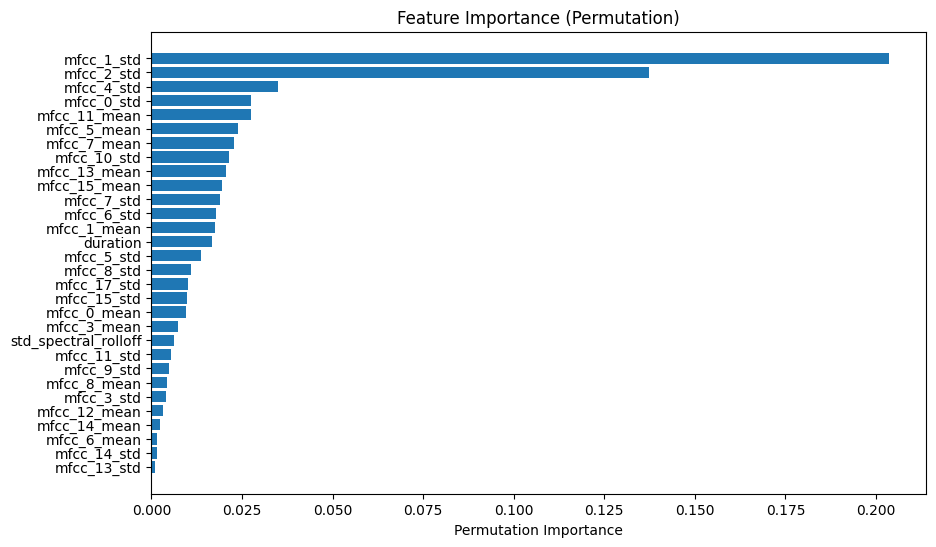

In [17]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
# Permutation importance is used to assess the importance of features by randomly shuffling the values of each feature and measuring the decrease in model performance.
# We compute the permutation importance on the training data (X_train_selected) and target labels (y_train) using the best model (best_model).

result = permutation_importance(
    best_model,  # The trained model used for computing feature importance.
    X_train_selected,  # The selected training features after feature selection.
    y_train,  # The target variable for training.
    n_repeats=10,  # Number of times to permute each feature (higher values provide more stable results).
    random_state=42,  # Setting a random state for reproducibility.
    scoring='neg_root_mean_squared_error'  # We are using negative RMSE as the scoring metric for model performance.
)

# Extract and plot the feature importances
# We retrieve the mean importances of the features and their corresponding feature names.
importances = result.importances_mean  # Mean importance score for each feature.
feature_names = selected_features  # Names of the selected features.

# Plotting the Permutation Importance
# A horizontal bar chart is plotted to show the importance of each feature.
plt.figure(figsize=(10, 6))  # Set the figure size.
sorted_idx = importances.argsort()[::-1]  # Sorting features based on their importance in descending order.
plt.barh(range(len(importances)), importances[sorted_idx])  # Horizontal bar chart for feature importance.
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])  # Adding feature names as y-ticks.
plt.xlabel("Permutation Importance")  # Label for x-axis.
plt.title("Feature Importance (Permutation)")  # Title of the plot.
plt.gca().invert_yaxis()  # Invert y-axis so that the most important feature is at the top.
plt.show()  # Display the plot.


This process of feature selection, model evaluation, and importance analysis ensures that we can identify the most impactful features and validate the model's performance, ultimately leading to improved predictions and insights.
